# COVID19 - District Region

In [1]:
import urllib.request
import pandas as pd
import numpy as np

In [2]:
# Download data
import get_data
#get_data.get_data()

In [3]:
dfSP = pd.read_csv("data/dados_municipios_SP.csv")
dfSP

,date,state,city,place_type,confirmed,deaths,order_for_place,is_last,popEst,city_ibge_code,confirmed_per_100k_inhabitants,death_rate,DRS
0,2020-04-16,SP,TOTAL,state,11568,853,50,True,45919049.0,35.0,25.19216,0.0737,Indefinido
1,2020-04-15,SP,TOTAL,state,11043,778,49,False,45919049.0,35.0,24.04884,0.0705,Indefinido
2,2020-04-14,SP,TOTAL,state,9371,695,48,False,45919049.0,35.0,20.40765,0.0742,Indefinido
3,2020-04-13,SP,TOTAL,state,8895,608,47,False,45919049.0,35.0,19.37105,0.0684,Indefinido
4,2020-04-12,SP,TOTAL,state,8755,588,46,False,45919049.0,35.0,19.06616,0.0672,Indefinido
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2584,2020-04-14,SP,Águas de São Pedro,city,1,0,5,False,3451.0,3500600.0,28.97711,NaN,DRS 10 - Piracicaba
2585,2020-04-13,SP,Águas de São Pedro,city,1,0,4,False,3451.0,3500600.0,28.97711,NaN,DRS 10 - Piracicaba
2586,2020-04-12,SP,Águas de São Pedro,city,1,0,3,False,3451.0,3500600.0,28.97711,NaN,DRS 10 - Piracicaba
2587,2020-04-11,SP,Águas de São Pedro,city,1,0,2,False,3451.0,3500600.0,28.97711,NaN,DRS 10 - Piracicaba


# Model

In [4]:
# lista DRSs
DRS = list(dfSP["DRS"].unique())
DRS.remove("Indefinido")

In [5]:
#objective function Odeint solver
from scipy.integrate import odeint

def lossOdeint(point, data, death, s_0, e_0, a_0, i_0, r_0, d_0, startNCases, ratioRecovered, weigthCases, weigthRecov):
    size = len(data)
    beta, beta2, sigma, sigma2, sigma3, gamma, b = point
    
    def SEAIRD(y,t):
        S = y[0]
        E = y[1]
        A = y[2]
        I = y[3]
        R = y[4]
        D = y[5]
        p=0.2
        # beta2=beta
        y0=-(beta2*A+beta*I)*S #S
        y1=(beta2*A+beta*I)*S-sigma*E #E
        y2=sigma*E*(1-p)-gamma*A #A
        y3=sigma*E*p-gamma*I-sigma2*I-sigma3*I#I
        y4=b*I+gamma*A+sigma2*I #R
        y5=max(0,1.-(y0+y1+y2+y3+y4)) #D
        return [y0,y1,y2,y3,y4,y5]

    y0=[s_0,e_0,a_0,i_0,r_0,d_0]
    tspan=np.arange(0, size, 1)
    res=odeint(SEAIRD,y0,tspan)

    l1=0
    l2=0
    l3=0
    tot=0

    for i in range(0,len(data.values)):
        if data.values[i]>startNCases:
            l1 = l1+(res[i,3] - data.values[i])**2
            l2 = l2+(res[i,5] - death.values[i])**2
            l3 = l3+(res[i,4] - data.values[i]*ratioRecovered)**2
            tot+=1
    l1=np.sqrt(l1/max(1,tot))
    l2=np.sqrt(l2/max(1,tot))
    l3=np.sqrt(l3/max(1,tot))
    
    #weight for cases
    u = weigthCases  #Brazil US 0.1
    w = weigthRecov
    #weight for deaths
    v = max(0,1. - u - w)
    
    return u*l1 + v*l2 + w*l3

In [6]:
# Parametros iniciais
dfparam = pd.read_csv("data/param.csv")
dfparam

,DRS,start-date,prediction-range,s0,e0,a0,i0,r0,d0,START,RATIO,WCASES,WREC
0,DRS 01 - Grande São Paulo,2020-03-15,60,280000.0,0.0001,0.0001,0.0001,0.0001,0.0001,1500,0.1,0.4,0.1
1,DRS 02 - Araçatuba,2020-04-01,60,100.0,0.0001,0.0001,0.0001,0.0001,0.0001,0,0.1,0.4,0.1
2,DRS 03 - Araraquara,2020-04-01,60,100.0,0.0001,0.0001,0.0001,0.0001,0.0001,0,0.1,0.4,0.1
3,DRS 04 - Baixada Santista,2020-04-01,60,8000.0,0.0001,0.0001,0.0001,0.0001,0.0001,0,0.1,0.4,0.1
4,DRS 05 - Barretos,2020-04-01,60,1000.0,0.0001,0.0001,0.0001,0.0001,0.0001,0,0.1,0.4,0.1
5,DRS 06 - Bauru,2020-04-01,60,1000.0,0.0001,0.0001,0.0001,0.0001,0.0001,0,0.1,0.4,0.1
6,DRS 07 - Campinas,2020-04-01,60,8000.0,0.0001,0.0001,0.0001,0.0001,0.0001,0,0.1,0.4,0.1
7,DRS 08 - Franca,2020-04-01,60,1000.0,0.0001,0.0001,0.0001,0.0001,0.0001,0,0.1,0.4,0.1
8,DRS 09 - Marília,2020-04-01,60,500.0,0.0001,0.0001,0.0001,0.0001,0.0001,0,0.1,0.4,0.1
9,DRS 10 - Piracicaba,2020-04-01,60,1000.0,0.0001,0.0001,0.0001,0.0001,0.0001,0,0.1,0.4,0.1


In [7]:
# Otimiza parametros iniciais

In [8]:
# Carrega solver
import Learner

In [9]:
for districtRegion in DRS:
    query = dfparam.query('DRS == "{}"'.format(districtRegion)).reset_index()
    parameters = np.array(query.iloc[:, 2:])[0]
    
    #learner = Learner.Learner(districtRegion, lossOdeint, *parameters)
    #learner.train()

# Plots

In [10]:
import matplotlib.pyplot as plt
import covid_plots

In [11]:
def loadDataFrame(filename):
    df= pd.read_pickle(filename)
    df.columns = [c.lower().replace(' ', '_') for c in df.columns]
    df.columns = [c.lower().replace('(', '') for c in df.columns]
    df.columns = [c.lower().replace(')', '') for c in df.columns]
    return df

In [12]:
#DRS 01 - Grande São Paulo
#DRS 02 - Araçatuba
#DRS 03 - Araraquara
#DRS 04 - Baixada Santista
#DRS 05 - Barretos
#DRS 06 - Bauru
#DRS 07 - Campinas
#DRS 08 - Franca
#DRS 09 - Marília
#DRS 10 - Piracicaba
#DRS 11 - Presidente Prudente
#DRS 12 - Registro
#DRS 13 - Ribeirão Preto
#DRS 14 - São João da Boa Vista
#DRS 15 - São José do Rio Preto
#DRS 16 - Sorocaba
#DRS 17 - Taubaté

districtRegion = "DRS 01 - Grande São Paulo"
opt = 0
version = "1"

query = dfparam.query('DRS == "{}"'.format(districtRegion)).reset_index()
startdate = query['start-date'][0]
predict_range = query['prediction-range'][0]

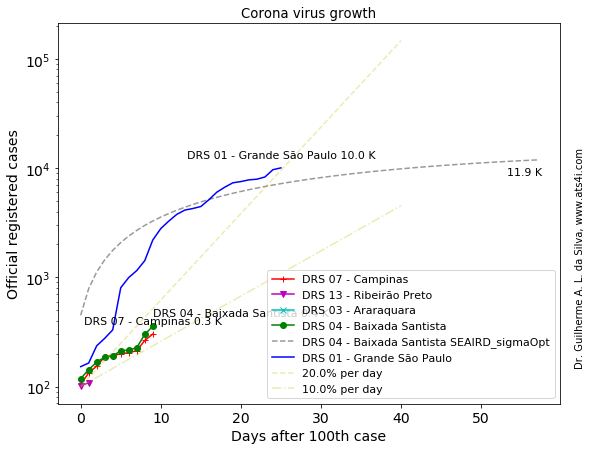

Infection speed= 4.69541227340769
Day with the maximum infections occurred= 15
Total number of recorded infected people at the infection’s end= 10833
Errors =  [0.3585625521319866, 0.6827756909632723]


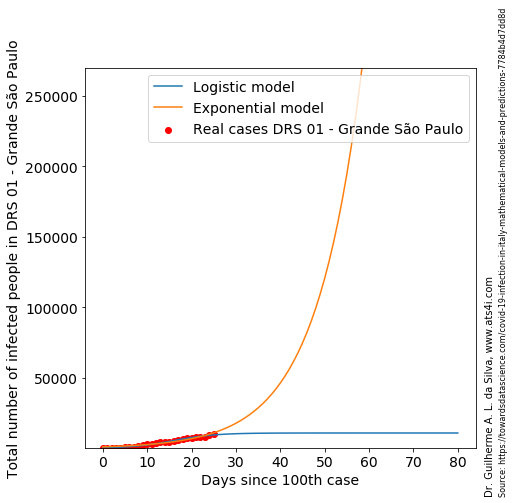

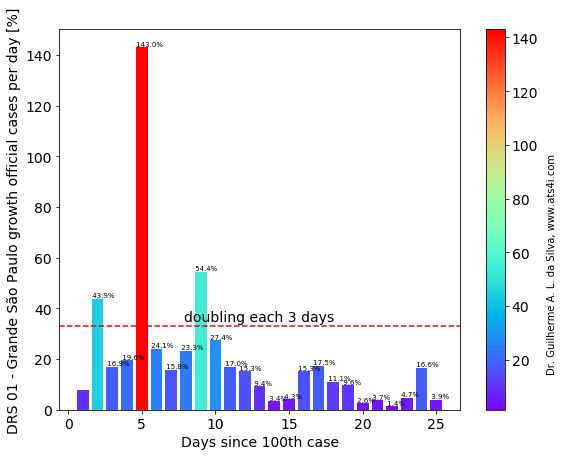

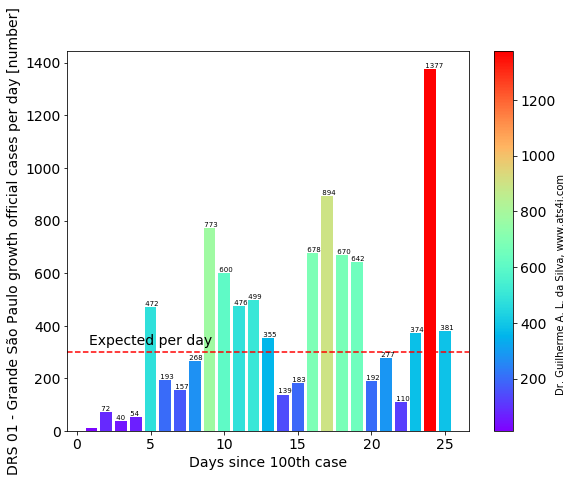

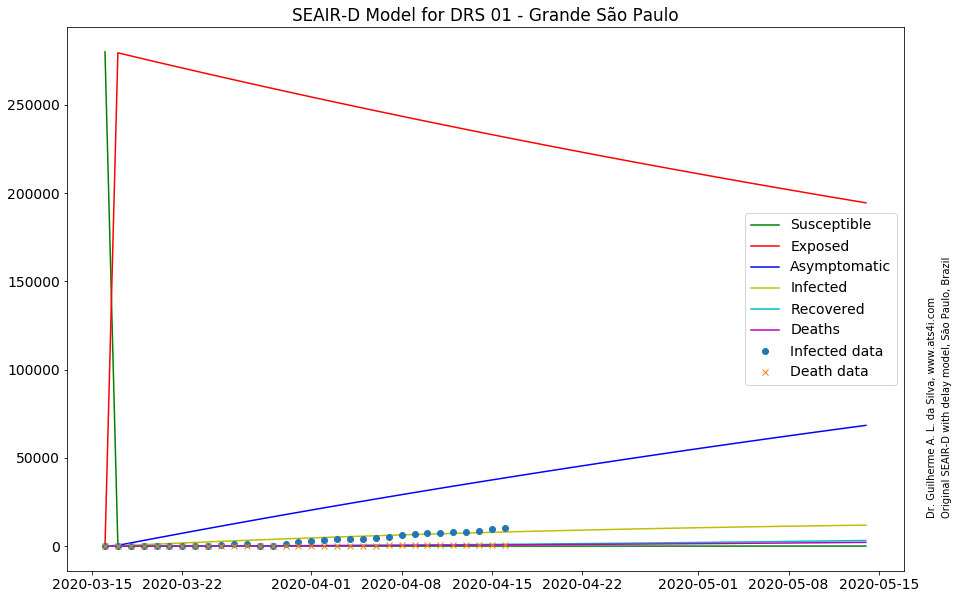

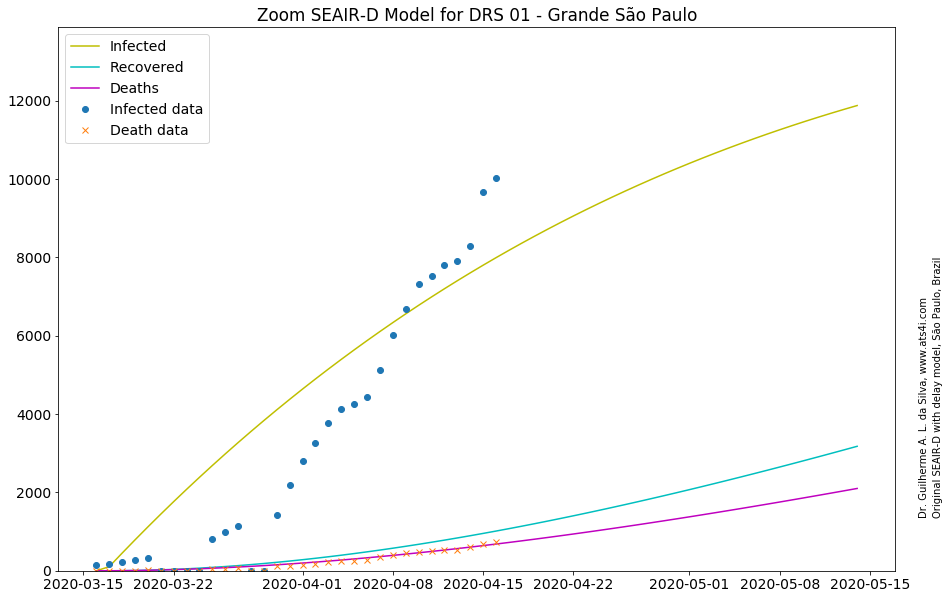

In [13]:
covid_plots.covid_plots(districtRegion, startdate,predict_range, opt, version, show=True)